## Analyze DB

In [ ]:
#pip install pyodbc
#pip install sqlachemy
#pip install pandas
#pip install networkx


In [12]:
import pandas as pd
from sqlalchemy import create_engine

user = 'tadas'
password = 'Bulviukose54!'
host = 'LTN5CG0312ZM6\SQLEXPRESS'
database = 'AdventureWorks2019'

engine = create_engine(
    'mssql+pyodbc://'
    f'{user}:{password}@{host}/{database}?' # username:pwd@server:port/database
    'TrustServerCertificate=yes&'
    'driver=ODBC+Driver+17+for+SQL+Server'
    )

test = pd.read_sql("select * from INFORMATION_SCHEMA.TABLES", engine)
test.head(30)


,TABLE_SCHEMA,Num_Tables
0,dbo,3
1,HumanResources,12
2,Person,15
3,Production,28
4,Purchasing,7
5,Sales,26


### Retrieve information about the tables

Start with depdenencies extraction and formulating a query text for each dependency to later retrieve counts about each table.

In [2]:
tdeps = pd.read_sql(
      """SELECT [source] = baseTable.name
	  ,[source_schema] = schema_name(baseTable.schema_id)
    ,[target] = refdTable.name
	  ,[target_schema] = schema_name(refdTable.schema_id)
	  ,[link] = baseTable.name + '.' + baseCol.name + '->' +  refdTable.name + '.' + refdCol.name
	  ,[qry] = 'select link=''' + baseTable.name + '.' + baseCol.name + '->' +  refdTable.name + '.' + refdCol.name + ''',source=''' + baseTable.name + ''',source_count= (select count(1) from ' + schema_name(baseTable.schema_id) + '.' + baseTable.name + '), ' + 
			          'target=''' + refdTable.name + ''',target_count= (select count(1) from '+ schema_name(refdTable.schema_id) + '.' + refdTable.name + '), ' +
					  'fk_count= (select count(1) from ' + schema_name(baseTable.schema_id) + '.' + baseTable.name + ' where ' + baseCol.name + ' is not null)'
					  


  --INTO #refs
  FROM [sys].[foreign_key_columns] fkc
 
  outer apply (select * from sys.tables o where o.object_id = fkc.[parent_object_id]) baseTable
  outer apply (select * from sys.columns o where o.object_id = fkc.[parent_object_id] and o.column_id = fkc.parent_column_id) baseCol
  outer apply (select * from sys.tables o where o.object_id = fkc.[referenced_object_id]) refdTable
  outer apply (select * from sys.columns o where o.object_id = fkc.[referenced_object_id] and o.column_id = fkc.referenced_column_id) refdCol""",
  engine)

tdeps.head()

,source,source_schema,target,target_schema,link,qry
0,Customer,Sales,SalesTerritory,Sales,Customer.TerritoryID->SalesTerritory.TerritoryID,select link='Customer.TerritoryID->SalesTerrit...
1,SalesOrderHeader,Sales,SalesTerritory,Sales,SalesOrderHeader.TerritoryID->SalesTerritory.T...,select link='SalesOrderHeader.TerritoryID->Sal...
2,SalesPerson,Sales,SalesTerritory,Sales,SalesPerson.TerritoryID->SalesTerritory.Territ...,select link='SalesPerson.TerritoryID->SalesTer...
3,SalesTerritoryHistory,Sales,SalesTerritory,Sales,SalesTerritoryHistory.TerritoryID->SalesTerrit...,select link='SalesTerritoryHistory.TerritoryID...
4,StateProvince,Person,SalesTerritory,Sales,StateProvince.TerritoryID->SalesTerritory.Terr...,select link='StateProvince.TerritoryID->SalesT...


Now let's iterate over dependencies and run queries to get some basic statistics about the site of source/target tables and FK.

In [3]:
qry = ""
for i, r in tdeps.iterrows():
    qry += "\n" + r["qry"]
    if i < tdeps.index.size - 1:
        qry += "\n union all"

#print(qry)

tdepstats = pd.read_sql(qry, engine)
tdepstats.head(5)

,link,source,source_count,target,target_count,fk_count
0,Customer.TerritoryID->SalesTerritory.TerritoryID,Customer,19820,SalesTerritory,10,19820
1,SalesOrderHeader.TerritoryID->SalesTerritory.T...,SalesOrderHeader,31465,SalesTerritory,10,31465
2,SalesPerson.TerritoryID->SalesTerritory.Territ...,SalesPerson,17,SalesTerritory,10,14
3,SalesTerritoryHistory.TerritoryID->SalesTerrit...,SalesTerritoryHistory,17,SalesTerritory,10,17
4,StateProvince.TerritoryID->SalesTerritory.Terr...,StateProvince,181,SalesTerritory,10,181


Let's add this information to the dependies list.

In [4]:
tdeps_wstats = pd.concat([tdeps, tdepstats], join="inner", axis=1)
tdeps_wstats.head(20)

,source,source_schema,target,target_schema,link,qry,link,source,source_count,target,target_count,fk_count
0,Customer,Sales,SalesTerritory,Sales,Customer.TerritoryID->SalesTerritory.TerritoryID,select link='Customer.TerritoryID->SalesTerrit...,Customer.TerritoryID->SalesTerritory.TerritoryID,Customer,19820,SalesTerritory,10,19820
1,SalesOrderHeader,Sales,SalesTerritory,Sales,SalesOrderHeader.TerritoryID->SalesTerritory.T...,select link='SalesOrderHeader.TerritoryID->Sal...,SalesOrderHeader.TerritoryID->SalesTerritory.T...,SalesOrderHeader,31465,SalesTerritory,10,31465
2,SalesPerson,Sales,SalesTerritory,Sales,SalesPerson.TerritoryID->SalesTerritory.Territ...,select link='SalesPerson.TerritoryID->SalesTer...,SalesPerson.TerritoryID->SalesTerritory.Territ...,SalesPerson,17,SalesTerritory,10,14
3,SalesTerritoryHistory,Sales,SalesTerritory,Sales,SalesTerritoryHistory.TerritoryID->SalesTerrit...,select link='SalesTerritoryHistory.TerritoryID...,SalesTerritoryHistory.TerritoryID->SalesTerrit...,SalesTerritoryHistory,17,SalesTerritory,10,17
4,StateProvince,Person,SalesTerritory,Sales,StateProvince.TerritoryID->SalesTerritory.Terr...,select link='StateProvince.TerritoryID->SalesT...,StateProvince.TerritoryID->SalesTerritory.Terr...,StateProvince,181,SalesTerritory,10,181
5,PersonPhone,Person,PhoneNumberType,Person,PersonPhone.PhoneNumberTypeID->PhoneNumberType...,select link='PersonPhone.PhoneNumberTypeID->Ph...,PersonPhone.PhoneNumberTypeID->PhoneNumberType...,PersonPhone,19972,PhoneNumberType,3,19972
6,BillOfMaterials,Production,Product,Production,BillOfMaterials.ProductAssemblyID->Product.Pro...,select link='BillOfMaterials.ProductAssemblyID...,BillOfMaterials.ProductAssemblyID->Product.Pro...,BillOfMaterials,2679,Product,504,2576
7,BillOfMaterials,Production,Product,Production,BillOfMaterials.ComponentID->Product.ProductID,select link='BillOfMaterials.ComponentID->Prod...,BillOfMaterials.ComponentID->Product.ProductID,BillOfMaterials,2679,Product,504,2679
8,ProductCostHistory,Production,Product,Production,ProductCostHistory.ProductID->Product.ProductID,select link='ProductCostHistory.ProductID->Pro...,ProductCostHistory.ProductID->Product.ProductID,ProductCostHistory,395,Product,504,395
9,ProductDocument,Production,Product,Production,ProductDocument.ProductID->Product.ProductID,select link='ProductDocument.ProductID->Produc...,ProductDocument.ProductID->Product.ProductID,ProductDocument,32,Product,504,32


Let's get some information about the table columns. TBD on the possibilities to get some value from these relationships.

In [5]:
qry = """
    select 
    [table_id] = c1.object_id, 
    [schema_name] = schema_name(t.schema_id), 
    [table_name] = t.name,  
    [column_name] = c1.name, 
    [primary_key_name] = keycol.name 
    from sys.columns c1
    outer apply (
        select name from sys.columns c2 
        where c1.object_id = c2.object_id and c2.is_identity = 1
    ) keycol
    join sys.tables t on c1.object_id = t.object_id
"""

tcols = pd.read_sql(qry, engine)
tcols.head(20)

,table_id,schema_name,table_name,column_name,primary_key_name
0,30623152,Sales,SalesTaxRate,ModifiedDate,SalesTaxRateID
1,30623152,Sales,SalesTaxRate,Name,SalesTaxRateID
2,30623152,Sales,SalesTaxRate,rowguid,SalesTaxRateID
3,30623152,Sales,SalesTaxRate,SalesTaxRateID,SalesTaxRateID
4,30623152,Sales,SalesTaxRate,StateProvinceID,SalesTaxRateID
5,30623152,Sales,SalesTaxRate,TaxRate,SalesTaxRateID
6,30623152,Sales,SalesTaxRate,TaxType,SalesTaxRateID
7,66099276,Sales,PersonCreditCard,BusinessEntityID,None
8,66099276,Sales,PersonCreditCard,CreditCardID,None
9,66099276,Sales,PersonCreditCard,ModifiedDate,None


#### TO DO:
Consider what other DB objects might be important for the analysis.

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



## Analyze Graphs

### Inspect Graphs

Start with creating a simple graph from the extracted information. Note: currently no node/edge features are being added here.

We should think on how we could categorize nodes and edges. 

For example, a node could be classified either as Table, View, Programmability object etc; an edge could be classified either as ForeignKey, Containment, Many2Many (derived), Usage in programmability object, etc.

Features could include the statistics of tables, field values, possibly vectorization or categorization.

In [6]:
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from networkx.algorithms import approximation
# import plotly.graph_objects as go

from networkx.algorithms import community

matplotlib.rcParams['figure.figsize'] = [20, 12]

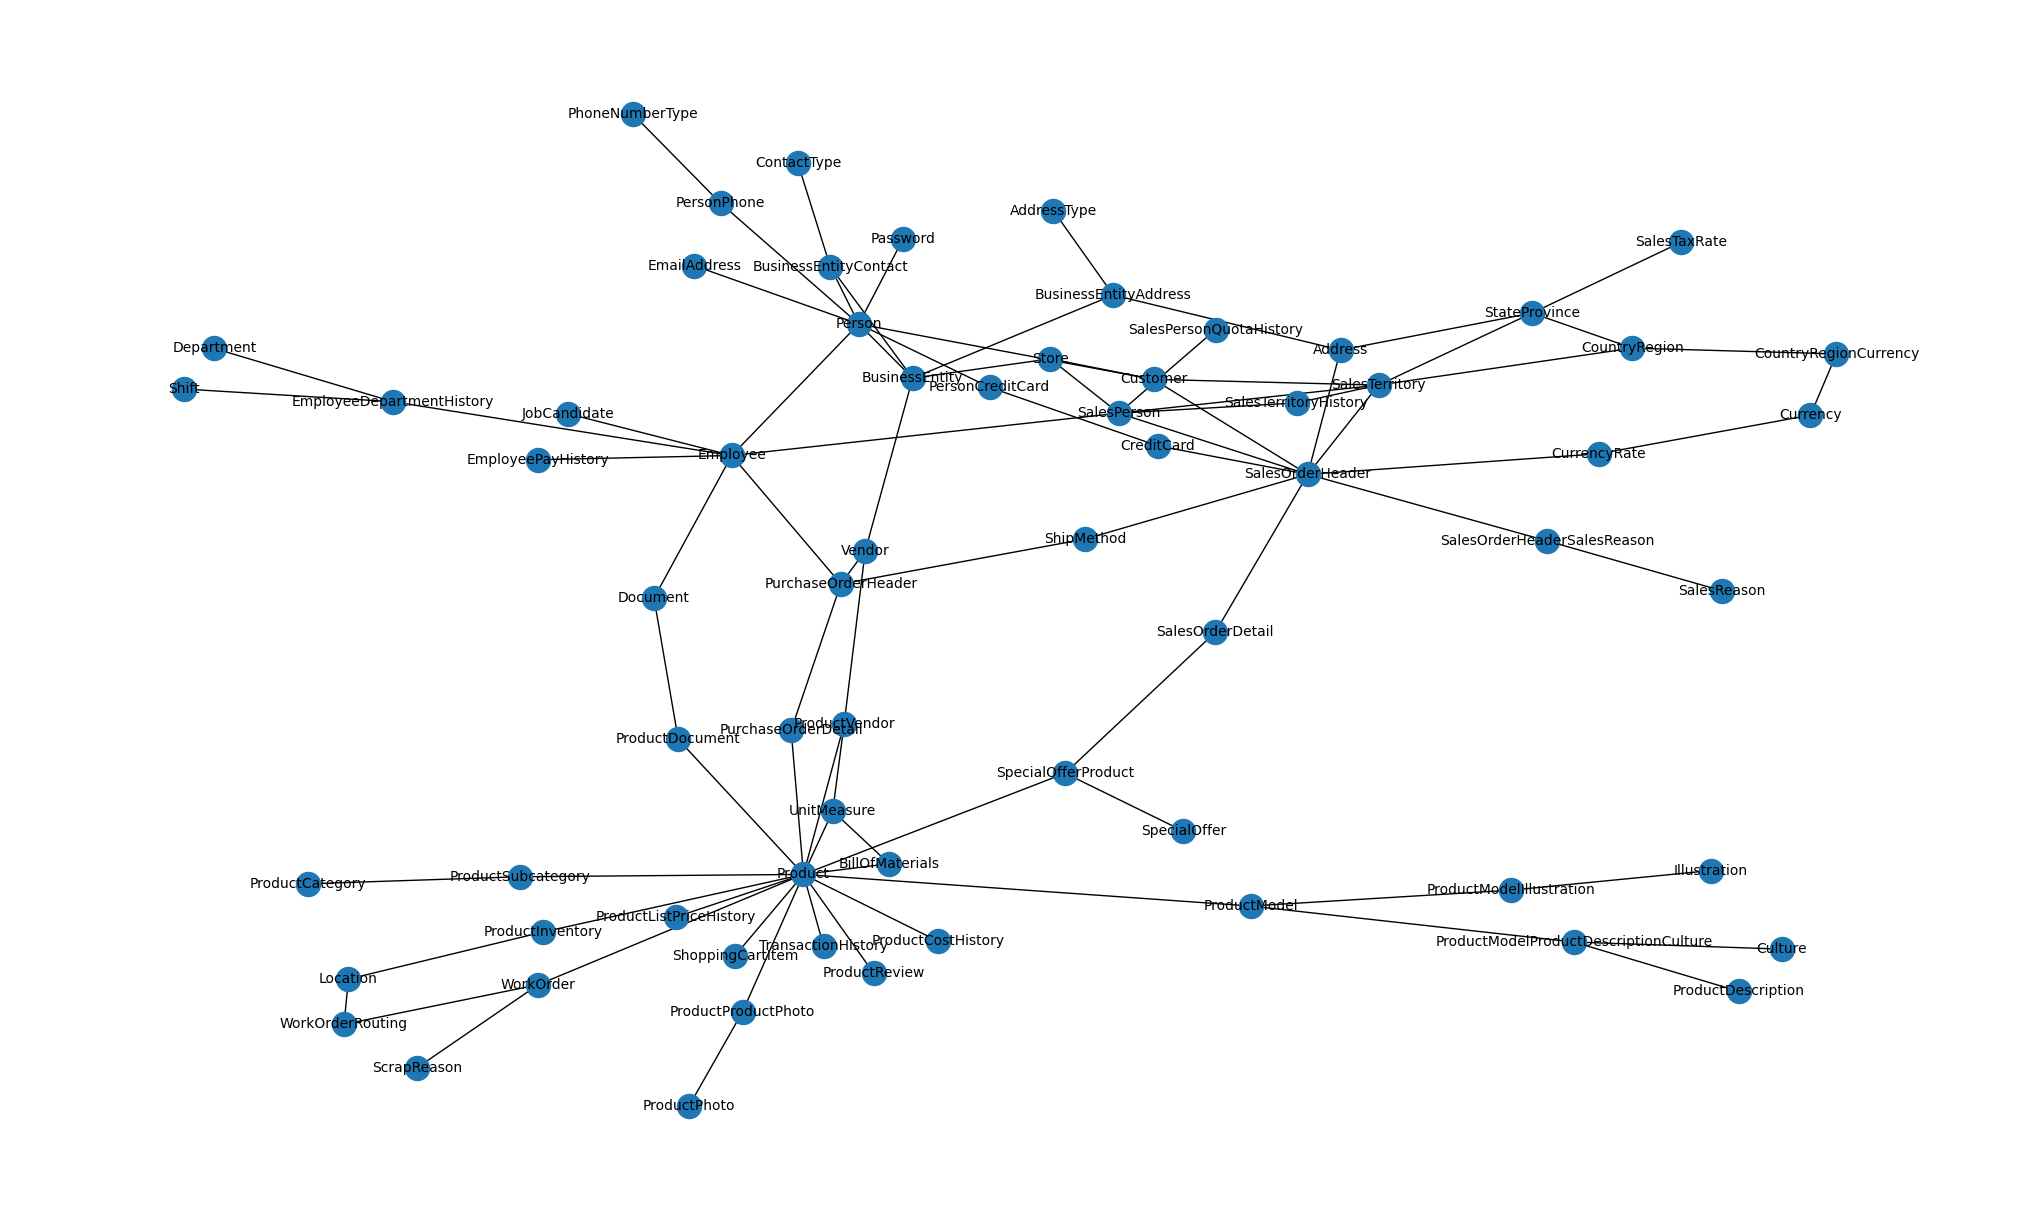

In [7]:
#though directed graph is right representation of the dependencies, 
#non directed allows more analysis to be performed using networkx libraries

#G = nx.DiGraph()
G = nx.Graph()

#todo: provide features of nodes/edges here as well
G = nx.from_pandas_edgelist(tdeps, source="source", 
                            target="target", 
                            create_using=G)

#note: some tests with different layouts
#pos = nx.circular_layout(G)
#pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G)
#nx.draw(G, pos=nx.random_layout(G))
nx.draw(G, pos)
nx.draw_networkx_labels(G, pos, font_size=10)
#plt.figure(figsize=(20, 15), dpi=60)
plt.show()

#### Node-level Task Types

Eigenvector centrality

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html

In [8]:
node_eigenvector = nx.eigenvector_centrality(G, max_iter=10000)
sorted((f"{c:0.3f}", v) for v, c in node_eigenvector.items())

[('0.006', 'PhoneNumberType'),
 ('0.007', 'Department'),
 ('0.007', 'Shift'),
 ('0.009', 'AddressType'),
 ('0.009', 'Illustration'),
 ('0.010', 'Culture'),
 ('0.010', 'ProductDescription'),
 ('0.010', 'SalesReason'),
 ('0.011', 'ContactType'),
 ('0.014', 'Currency'),
 ('0.015', 'CountryRegionCurrency'),
 ('0.015', 'SalesTaxRate'),
 ('0.026', 'EmailAddress'),
 ('0.026', 'Password'),
 ('0.027', 'EmployeePayHistory'),
 ('0.027', 'JobCandidate'),
 ('0.028', 'PersonPhone'),
 ('0.031', 'EmployeeDepartmentHistory'),
 ('0.033', 'SalesPersonQuotaHistory'),
 ('0.034', 'ProductCategory'),
 ('0.034', 'ProductPhoto'),
 ('0.037', 'BusinessEntityAddress'),
 ('0.037', 'ScrapReason'),
 ('0.038', 'PersonCreditCard'),
 ('0.039', 'ProductModelIllustration'),
 ('0.039', 'SpecialOffer'),
 ('0.041', 'ProductModelProductDescriptionCulture'),
 ('0.042', 'SalesOrderHeaderSalesReason'),
 ('0.043', 'CurrencyRate'),
 ('0.046', 'Location'),
 ('0.048', 'WorkOrderRouting'),
 ('0.049', 'BusinessEntityContact'),
 ('0.0

Betweeness centrality

https://networkx.org/documentation/stable/auto_examples/algorithms/plot_betweenness_centrality.html

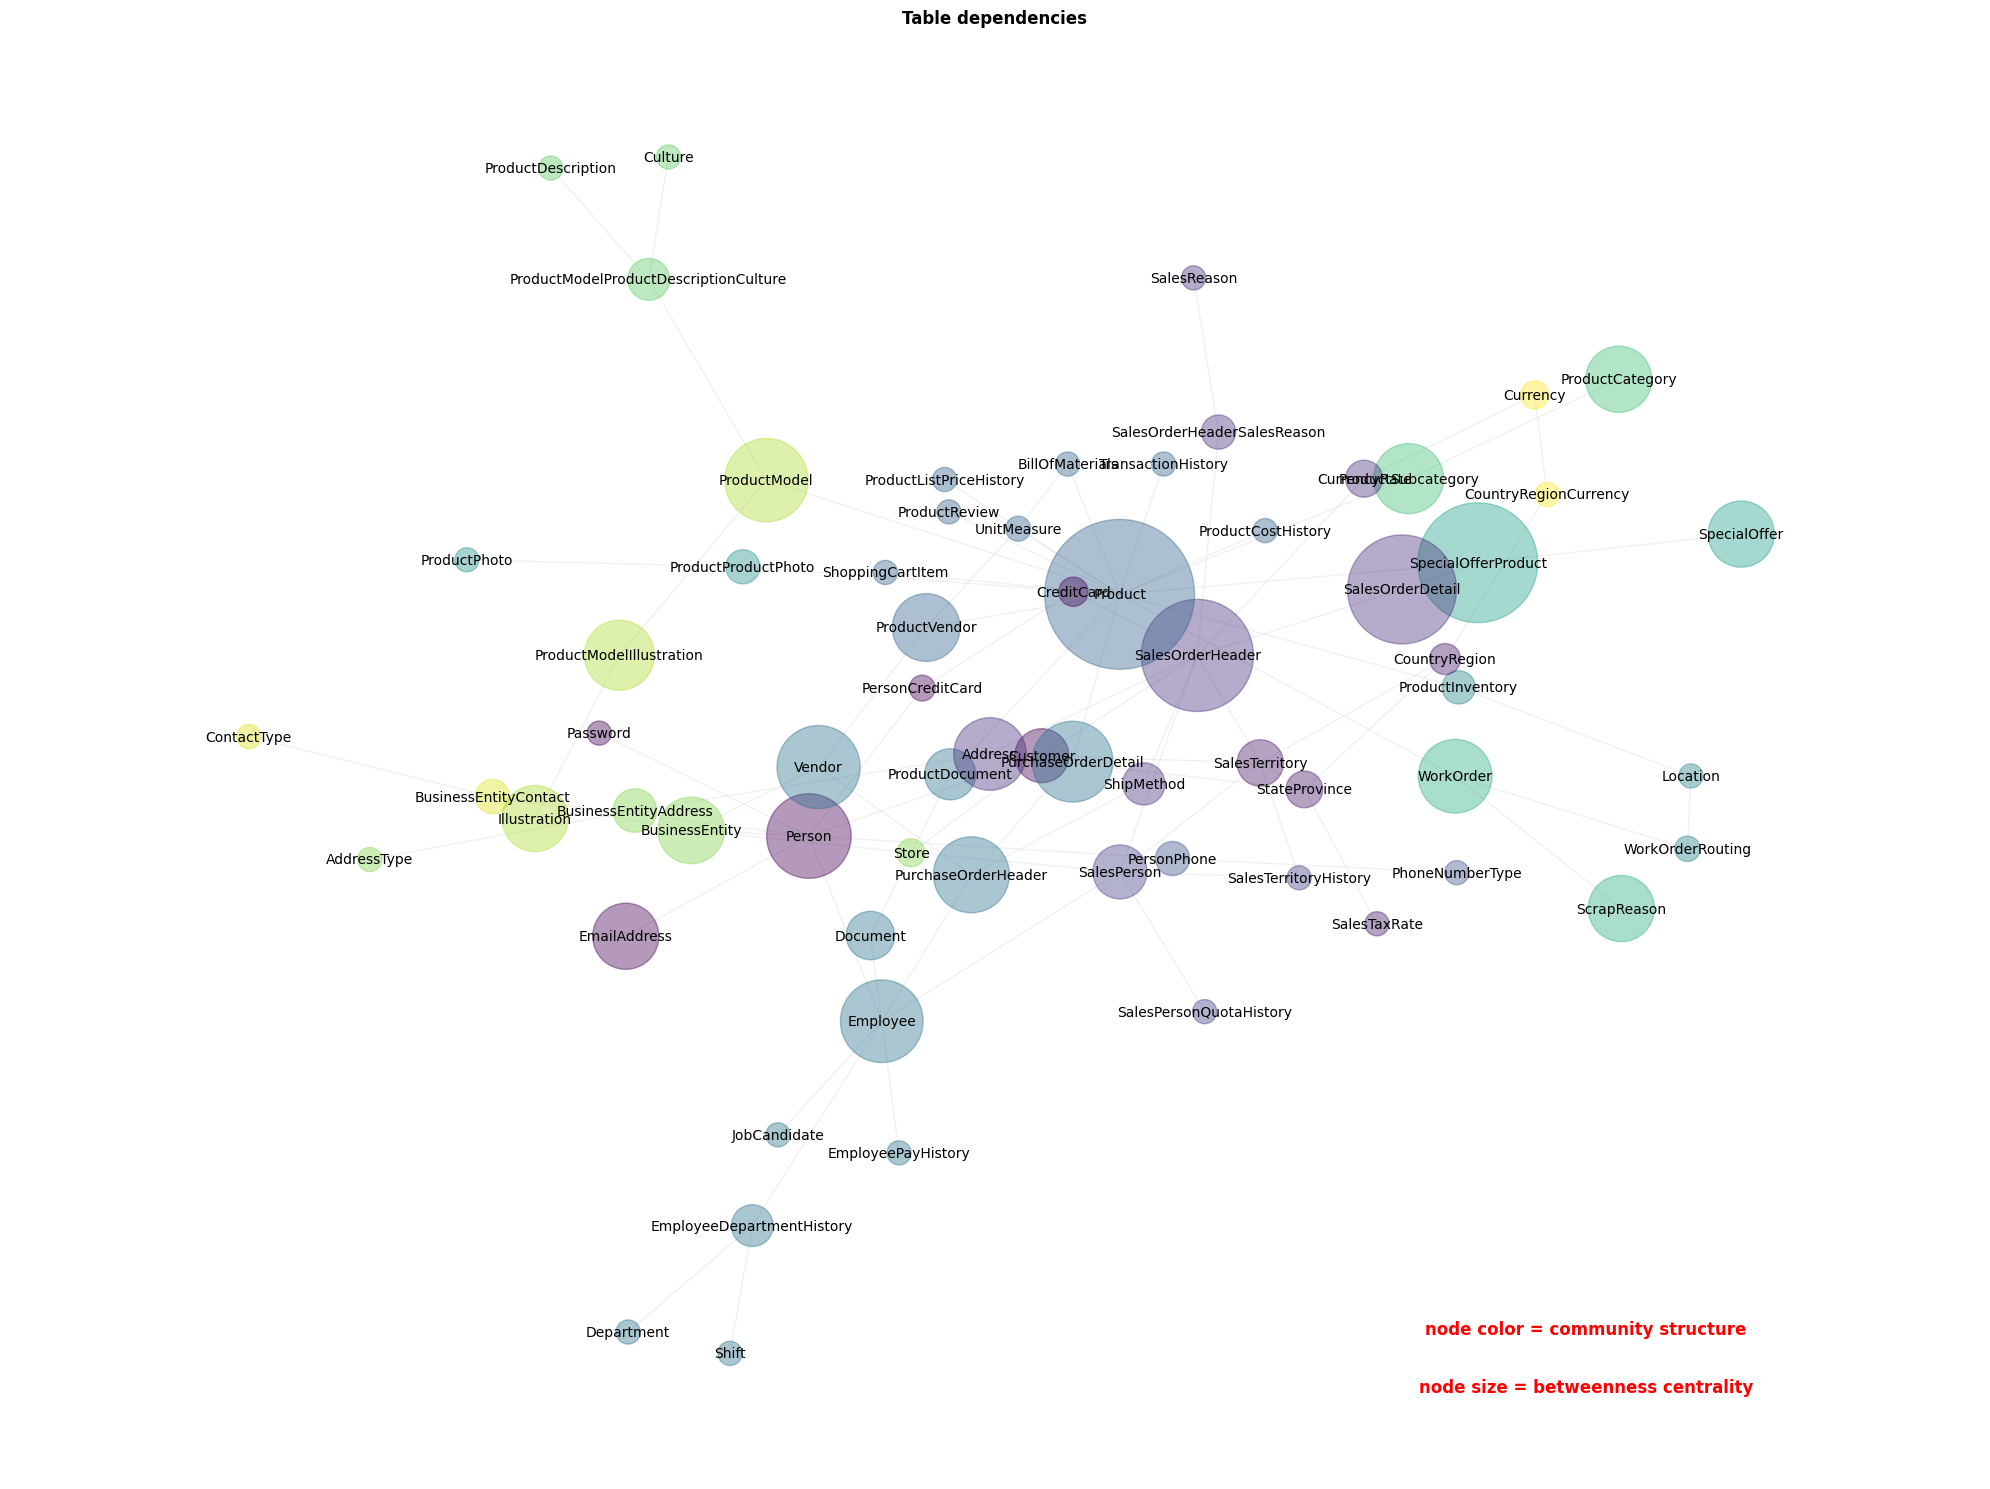

In [9]:
# largest connected component
components = nx.connected_components(G)
largest_component = max(components, key=len)
H = G.subgraph(largest_component)
# compute centrality
centrality = nx.betweenness_centrality(H, k=10, endpoints=True)
# compute community structure
lpc = nx.community.label_propagation_communities(H)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = [community_index[n] for n in H]
node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)
nx.draw_networkx_labels(G, pos, font_size=10)
# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 12}
ax.set_title("Table dependencies", font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "node color = community structure",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.06,
    "node size = betweenness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()